In [2]:
import pandas as pd

# Load the Excel file (replace 'nmr_data.xlsx' with your file name)
df = pd.read_excel('All_aligned_spectra v3.xlsx')

# Display basic info about the dataset
print("=== Dataset Structure ===")
print(f"Shape (rows, columns): {df.shape}")
print("\n=== First 5 Rows ===")
print(df.head())

# Check for missing values
print("\n=== Missing Values ===")
print(df.isnull().sum())

# Summary statistics for numeric columns (if applicable)
print("\n=== Summary Statistics ===")
print(df.describe(include='all'))

=== Dataset Structure ===
Shape (rows, columns): (66, 1397)

=== First 5 Rows ===
   ClassID           Primary ID  -1.93978  -1.92978  -1.91978  -1.90978  \
0     EVOO  296_ControlNMR-EVOO -0.037742 -0.037742 -0.003322 -0.007332   
1     EVOO  297_ControlNMR-EVOO -0.020159 -0.020159 -0.020159 -0.014388   
2     EVOO  298_ControlNMR-EVOO -0.042973 -0.042973 -0.025936 -0.014853   
3     EVOO  302_ControlNMR-EVOO -0.053067 -0.053067 -0.022915 -0.017543   
4     EVOO  304_ControlNMR-EVOO -0.081616 -0.072992 -0.066752 -0.050121   

   -1.89978  -1.88978  -1.87978  -1.86978  ...     11.91     11.92     11.93  \
0 -0.005643 -0.000488  0.022687  0.045279  ...  0.430493  0.416529  0.400159   
1  0.005981  0.011637  0.032143  0.046074  ...  0.449157  0.419575  0.400303   
2  0.004859 -0.001755  0.018581  0.027658  ...  0.391275  0.373789  0.363355   
3 -0.010908  0.002723  0.013443  0.027859  ...  0.416158  0.393003  0.385488   
4 -0.039328 -0.023604 -0.010942 -0.011524  ...  0.375700  0.394719 

Remaining samples: 57


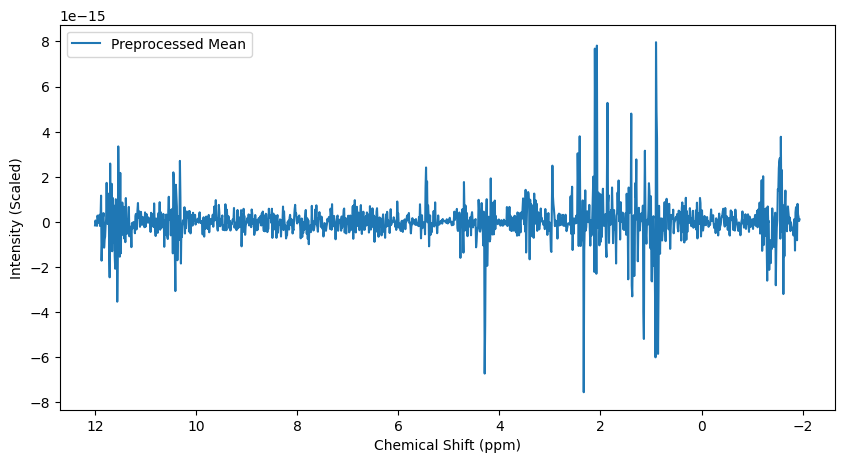

In [3]:
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

# --- 1. Handle Missing Values ---
df_clean = df.dropna(subset=['ClassID'])  # Drop rows with missing ClassID
print(f"Remaining samples: {len(df_clean)}")

# --- 2. Separate Metadata and NMR Data ---
X = df_clean.select_dtypes(include=['float64'])  # NMR features (ppm columns)
metadata = df_clean[['ClassID', 'Primary ID']]   # Retain metadata

# --- 3. Baseline Correction (ALS) ---
def baseline_correction(y, lam=1e4, p=0.01, niter=10):
    """Asymmetric Least Squares (ALS) baseline correction."""
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L-2))
    w = np.ones(L)
    for _ in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.T)
        baseline = spsolve(Z, w*y)
        w = p * (y > baseline) + (1-p) * (y <= baseline)
    return baseline

# Apply to each spectrum (row)
X_corrected = X.apply(lambda row: row - baseline_correction(row.values), axis=1)

# --- 4. Normalization (PQN) ---
ref_spectrum = X_corrected.median(axis=0)  # Reference spectrum (median)
X_normalized = X_corrected.div(X_corrected.sum(axis=1), axis=0) * ref_spectrum.sum()

# --- 5. Scaling (StandardScaler) ---
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_normalized), columns=X.columns)

# --- 6. Outlier Detection (Optional) ---
Q1 = X_scaled.quantile(0.25)
Q3 = X_scaled.quantile(0.75)
IQR = Q3 - Q1
outliers = ((X_scaled < (Q1 - 1.5 * IQR)) | (X_scaled > (Q3 + 1.5 * IQR))).any(axis=1)
X_clean = X_scaled[~outliers]
metadata_clean = metadata[~outliers]

# --- 7. Visual Validation ---
plt.figure(figsize=(10, 5))
plt.plot(X.columns.astype(float), X_scaled.mean(), label="Preprocessed Mean")
plt.xlabel("Chemical Shift (ppm)")
plt.ylabel("Intensity (Scaled)")
plt.gca().invert_xaxis()  # NMR convention (high to low ppm)
plt.legend()
plt.show()


=== Basic Statistics ===
                  mean       std       min       50%       max
-1.93978 -7.011935e-17  1.008889 -1.311258 -0.289848  1.412936
-1.92978 -7.401487e-17  1.008889 -1.313188 -0.285557  1.409851
-1.91978 -4.674623e-17  1.008889 -1.293979 -0.285676  1.402917
-1.90978  3.116416e-17  1.008889 -1.295114 -0.289623  1.410183
-1.89978 -4.674623e-17  1.008889 -1.302553 -0.299542  1.406819
-1.88978 -9.349247e-17  1.008889 -1.316973 -0.290545  1.411695
-1.87978  1.558208e-17  1.008889 -1.300735 -0.301663  1.417832
-1.86978 -1.558208e-17  1.008889 -1.294940 -0.297723  1.401476
-1.85978 -4.674623e-17  1.008889 -1.296234 -0.306850  1.399215
-1.84978  4.285071e-17  1.008889 -1.289657 -0.305409  1.413645

=== Class Distribution ===
ClassID
EVOO    19
HOSO    19
SO      19
Name: count, dtype: int64


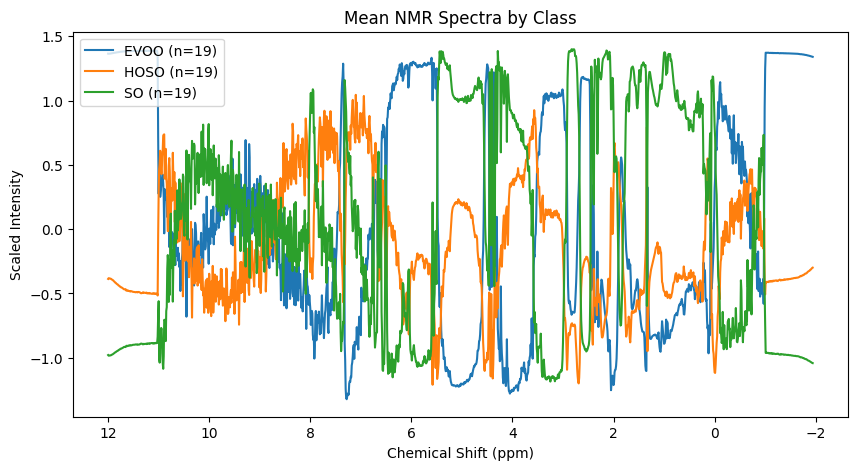

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Reload and clean the data (if needed)
df = pd.read_excel('All_aligned_spectra v3.xlsx')
df_clean = df.dropna(subset=['ClassID'])

# 2. Separate features and metadata properly
X = df_clean.select_dtypes(include=['number'])  # All numeric columns
metadata = df_clean[['ClassID', 'Primary ID']]

# 3. Simple scaling (skip complex preprocessing for now)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 4. Basic EDA
print("\n=== Basic Statistics ===")
print(X_scaled.describe().loc[['mean', 'std', 'min', '50%', 'max']].T.head(10))

print("\n=== Class Distribution ===")
print(metadata['ClassID'].value_counts())

# 5. Visualization
plt.figure(figsize=(10, 5))
for class_name in metadata['ClassID'].unique():
    class_mask = metadata['ClassID'] == class_name
    plt.plot(X.columns.astype(float), X_scaled[class_mask].mean(), 
             label=f'{class_name} (n={sum(class_mask)})')
plt.gca().invert_xaxis()
plt.xlabel("Chemical Shift (ppm)")
plt.ylabel("Scaled Intensity")
plt.title("Mean NMR Spectra by Class")
plt.legend()
plt.show()



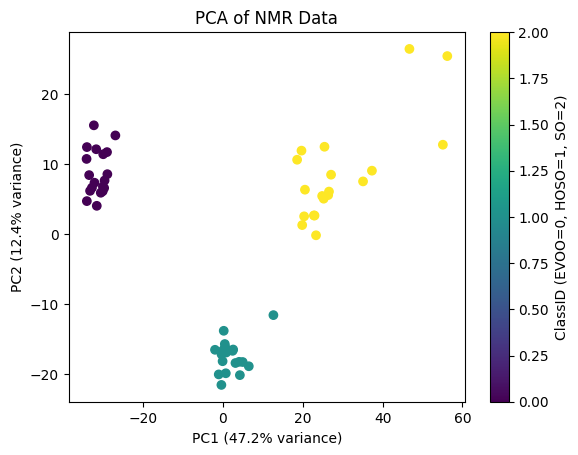

In [5]:
from sklearn.decomposition import PCA

# Reduce to 2 components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)  # Using standardized data

# Plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=metadata['ClassID'].astype('category').cat.codes, cmap='viridis')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
plt.colorbar(label="ClassID (EVOO=0, HOSO=1, SO=2)")
plt.title("PCA of NMR Data")
plt.show()

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# 1. Data Preparation
# Assuming X_scaled and metadata are already loaded
y = LabelEncoder().fit_transform(metadata['ClassID'])  # SO=0, HOSO=1, EVOO=2
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# 2. PLS-DA (Corrected Implementation)
pls = PLSRegression(n_components=2)
pls.fit(X_train, y_train)

# For PLSRegression, we need to manually threshold predictions
y_pred_pls = np.round(pls.predict(X_test)).astype(int)
y_pred_pls = np.clip(y_pred_pls, 0, 2)  # Ensure predictions stay within class labels
pls_acc = accuracy_score(y_test, y_pred_pls)

# 3. SVM
svm = SVC(kernel='rbf', C=10, gamma='scale', random_state=42)
svm.fit(X_train, y_train)
svm_acc = accuracy_score(y_test, svm.predict(X_test))

# 4. Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)
rf_acc = accuracy_score(y_test, rf.predict(X_test))

# Results
print(f"PLS-DA Accuracy: {pls_acc:.1%}")
print(f"SVM Accuracy: {svm_acc:.1%}")
print(f"Random Forest Accuracy: {rf_acc:.1%}")

# Confusion Matrix for PLS-DA (example)
print("\nPLS-DA Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_pls))



PLS-DA Accuracy: 100.0%
SVM Accuracy: 100.0%
Random Forest Accuracy: 100.0%

PLS-DA Confusion Matrix:
[[4 0 0]
 [0 4 0]
 [0 0 4]]


In [11]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix)
from sklearn.model_selection import cross_val_score
import numpy as np

def evaluate_model(model, X_test, y_test, model_name):
    # Handle PLS-DA specially since it outputs continuous values
    if model_name == "PLS-DA":
        y_pred = np.round(model.predict(X_test).flatten()).astype(int)
        y_pred = np.clip(y_pred, 0, 2)  # Ensure predictions stay within class labels
    else:
        y_pred = model.predict(X_test)
    
    print(f"\n{model_name} Evaluation:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.2f}")
    print(f"F1-Score: {f1_score(y_test, y_pred, average='weighted'):.2f}")
    
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        print(f"AUC-ROC: {roc_auc_score(y_test, y_proba, multi_class='ovr'):.2f}")
    elif model_name == "PLS-DA":
        print("AUC-ROC: Not available for PLS-DA (requires probability estimates)")
    else:
        print("AUC-ROC: Not available (no probability estimates)")
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
    print(f"CV Accuracy: {cv_scores.mean():.2f} (±{cv_scores.std():.2f})")

# Evaluate all models
for name, model in [("PLS-DA", pls), ("SVM", svm), ("Random Forest", rf)]:
    evaluate_model(model, X_test, y_test, name)

def predict_unlabeled(model, model_name, X_unlabeled):
    if model_name == "PLS-DA":
        predictions = np.round(model.predict(X_unlabeled).flatten()).astype(int)
        predictions = np.clip(predictions, 0, 2)
        probabilities = None  # PLS-DA doesn't provide probabilities
    elif hasattr(model, "predict_proba"):
        predictions = model.predict(X_unlabeled)
        probabilities = model.predict_proba(X_unlabeled)
    else:
        predictions = model.predict(X_unlabeled)
        probabilities = None
    
    return predictions, probabilities

# For evaluation
evaluate_model(pls, X_test, y_test, "PLS-DA")

# For prediction
unlabeled_pred, unlabeled_probs = predict_unlabeled(pls, "PLS-DA", X_unlabeled)


PLS-DA Evaluation:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
AUC-ROC: Not available for PLS-DA (requires probability estimates)
Confusion Matrix:
[[4 0 0]
 [0 4 0]
 [0 0 4]]
CV Accuracy: nan (±nan)

SVM Evaluation:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
AUC-ROC: Not available (no probability estimates)
Confusion Matrix:
[[4 0 0]
 [0 4 0]
 [0 0 4]]


C:\Users\Roqui\.virtualenvs\JupyterNotebook-syu32SrQ\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Roqui\.virtualenvs\JupyterNotebook-syu32SrQ\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Roqui\.virtualenvs\JupyterNotebook-syu32SrQ\Lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Roqui\.virtualenvs\JupyterNotebook-syu32SrQ\Lib\site-packages\sklearn\utils\_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Roqui\.virtualenvs\JupyterNotebook-syu32SrQ\Lib\s

CV Accuracy: 1.00 (±0.00)

Random Forest Evaluation:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
AUC-ROC: 1.00
Confusion Matrix:
[[4 0 0]
 [0 4 0]
 [0 0 4]]
CV Accuracy: 0.98 (±0.03)

PLS-DA Evaluation:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
AUC-ROC: Not available for PLS-DA (requires probability estimates)
Confusion Matrix:
[[4 0 0]
 [0 4 0]
 [0 0 4]]
CV Accuracy: nan (±nan)


C:\Users\Roqui\.virtualenvs\JupyterNotebook-syu32SrQ\Lib\site-packages\sklearn\model_selection\_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Roqui\.virtualenvs\JupyterNotebook-syu32SrQ\Lib\site-packages\sklearn\metrics\_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\Roqui\.virtualenvs\JupyterNotebook-syu32SrQ\Lib\site-packages\sklearn\metrics\_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Roqui\.virtualenvs\JupyterNotebook-syu32SrQ\Lib\site-packages\sklearn\utils\_param_validation.py", line 216, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Roqui\.virtualenvs\JupyterNotebook-syu32SrQ\Lib\s

NameError: name 'X_unlabeled' is not defined